# Purpose

The purpose of this notebook is to do the following:
   1. Process the dialogue using spacy and regex
   2. Use Word2Vec to see what words are most similar to each other
   3. Perform sentiment analysis for each contestant by season
   4. Using the Word2Vec findings to find the sentiment behind certain flavor pairings
   
## Part 1: Dialogue Processing

First, I will process and clean the dialogue. 

In [1]:
import pandas as pd

import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import nltk

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

import re
import string
spacy_nlp = spacy.load('en')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('clean.csv')
df.head()

,episode_num,season,episode,character,dialogue,role,gender
0,101,1,1,mel,thousands of people applied. it's been quite ...,host,female
1,101,1,1,mel,"just 12 have made it through, and over the ne...",host,female
2,101,1,1,mel,"their baking will be scrutinized, whatever th...",host,female
3,101,1,1,woman,i've been baking for 60 years. i suppose i'm ...,contestant,female
4,101,1,1,man,the thing that worries me the most is probabl...,contestant,male


In [4]:
df.replace({'\n': ' '}, regex=True, inplace=True)

In [5]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

df['dialogue'] = df.dialogue.map(alphanumeric).map(punc_lower)
df.head()

,episode_num,season,episode,character,dialogue,role,gender
0,101,1,1,mel,thousands of people applied it s been quite ...,host,female
1,101,1,1,mel,just have made it through and over the nex...,host,female
2,101,1,1,mel,their baking will be scrutinized whatever th...,host,female
3,101,1,1,woman,i ve been baking for years i suppose i m h...,contestant,female
4,101,1,1,man,the thing that worries me the most is probabl...,contestant,male


In [6]:
sq = lambda x: re.sub('[[].*?[]]','',x)
parens = lambda x: re.sub('\(.*\)', '', x)

df['dialogue'] = df.dialogue.map(sq).map(parens)

/Users/amyksu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Possible nested set at position 1
  """Entry point for launching an IPython kernel.


In [11]:
df.head()

,episode_num,season,episode,character,dialogue,role,gender
0,101,1,1,mel,thousands of people applied it s been quite ...,host,female
1,101,1,1,mel,just have made it through and over the nex...,host,female
2,101,1,1,mel,their baking will be scrutinized whatever th...,host,female
3,101,1,1,woman,i ve been baking for years i suppose i m h...,contestant,female
4,101,1,1,man,the thing that worries me the most is probabl...,contestant,male


In [7]:
df['character'] = df.character.replace('kimberly','kimberley')

### Spacy and Stop Words

Because my corpus of documents is based on subtitles from a TV show, there are a few sound bites that were caught in the corpus. As such, I will add these and some other words, as well as adding back some words to the stop words list. 

In [8]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [9]:
remove_stop_words = ['first', 'nine', 'even','six', 'down', 'least', 'without', 
'over', 'show', 'hundred', 'however', 'more', 'quite', 'under', 'done', 'latter', 'only', 'out', 'once','former', 'above',
 'front', 'did', 'make', 'seems', 'last', 'name', 'five', 'always', 'next', 'become', 'full', 'fifteen', 'serious', 'eight', 
 'whole', 'top', 'not', 'no', 'many', 'never', 'twelve', 'forty','sixty', 'fifty', 'twenty', 'ten',
 'less', 'enough', 'bottom', 'must',  'becoming', 'third', 'really', 'well', 
 'again', 'most', 'two','amount', 'none', 'eleven', 'beyond', 'empty', 'made', 
 'off', 'keep', 'three', 'four', 'otherwise', 'been', 'below', 'became']

for w in remove_stop_words:
    spacy_nlp.vocab[w].is_stop = False

In [10]:
add_sw = ['s', 'm', 'think', 'look', 'go', 've','welcome','day','get','will','do','um', 'hmm', 'oh', 'ohh', 'ho','da','de','hi','ha','d', 'a', 'm','t','s','ve','ve_get']

for w in add_sw:
    spacy_nlp.vocab[w].is_stop = True

In [11]:
def clean(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

In [12]:
lower_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).strip().lower() for row in df['dialogue'])

In [13]:
txt = [clean(doc) for doc in spacy_nlp.pipe(lower_cleaning, batch_size=5000, n_threads=-1)]

In [14]:
df['clean_text'] = txt

In [15]:
df.isnull().sum()

episode_num      0
season           0
episode          0
character        0
dialogue         0
role             0
gender           0
clean_text     772
dtype: int64

In [16]:
#Drop rows with no dialogue
total_rows = len(df.index)

# Drop na's 
df.dropna(subset=['clean_text'],inplace=True)
data_kept = len(df.index)/total_rows
print('Data Retained:'+str(round(data_kept*100,2))+' %')

Data Retained:90.63 %


## Topic Modeling

In [71]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [72]:
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

In [74]:
tfidf = TfidfVectorizer(stop_words = stop_words, max_df=0.05)
doc_word = tfidf.fit_transform(df['clean_text'])
pd.DataFrame(doc_word.toarray(), index=df['clean_text'], columns=tfidf.get_feature_names()).head(10)

,abandon,abate,abattoir,abba,abbey,abdul,ability,able,absence,absolute,...,zig,zing,zingy,zipan,zivania,zoe,zone,zoop,zorro,zwanzig
clean_text,,,,,,,,,,,,,,,,,,,,,
thousand people apply be quite come today start,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
make over next week most excited tent walk station ingredient recipe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
baking scrutinize experience,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
judge mary paul don know go recover prepare brand new challenge,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
new challenge be carefully design fill boot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
reveal brilliant baker judgment come deliver perfect cake bread biscuit dessert like off cut get good tasting off cut business,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fall short ask leave err,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
excel right miracle name star baker get shake make absolutely no idea crown winner come diana high worried,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
year travel royal county berkshire row down river lambourn unload mixing bowl pitch tent hide garden welford park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
nmf_model = NMF(8)
doc_topic = nmf_model.fit_transform(doc_word)

In [92]:
display_topics(nmf_model, tfidf.get_feature_names(), 20)


Topic  0
taste, lovely, color, beautiful, great, texture, mmm, love, let, inside, absolutely, way, yes, delicious, outside, biscuit, beautifully, fantastic, middle, pretty

Topic  1
dough, prove, butter, bread, shape, roll, second, rise, flour, knead, filling, add, start, loaf, wait, enrich, happy, long, cut, yeast

Topic  2
week, star, last, feel, next, home, think, bread, win, person, today, try, say, sorry, richard, tom, start, job, never, tent

Topic  3
cream, ice, meringue, sugar, add, egg, roll, jam, white, butter, fill, custard, pipe, lemon, swiss, mousse, mix, sort, flour, try

Topic  4
oven, cook, long, enough, cool, temperature, hot, longer, brown, way, keep, rise, half, golden, middle, big, five, sure, take, steam

Topic  5
layer, bottom, thick, thin, even, caramel, cut, ok, puff, three, ganache, butter, try, distinct, dark, raspberry, buttercream, turn, crispy, opera

Topic  6
challenge, set, mark, half, three, morning, technical, biscuit, four, signature, showstopper, rem

In [114]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ['Descriptions','Breads','Competition','Ingredients','Technique','Flavors','Challenges','Rankings'],
             columns = tfidf.get_feature_names())
topic_word.reset_index()
topic_word

,abandon,abate,abattoir,abba,abbey,abdul,ability,able,absence,absolute,...,zig,zing,zingy,zipan,zivania,zoe,zone,zoop,zorro,zwanzig
Descriptions,0.006,0.000,0.003,0.000,0.004,0.000,0.010,0.031,0.000,0.004,...,0.008,0.003,0.004,0.001,0.000,0.000,0.003,0.000,0.001,0.000
Breads,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.015,0.001,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Competition,0.000,0.006,0.002,0.000,0.001,0.001,0.000,0.010,0.000,0.007,...,0.001,0.000,0.001,0.000,0.013,0.001,0.012,0.000,0.000,0.000
Ingredients,0.002,0.000,0.000,0.001,0.000,0.000,0.000,0.043,0.001,0.000,...,0.000,0.002,0.000,0.000,0.000,0.001,0.001,0.002,0.000,0.002
Technique,0.002,0.000,0.000,0.000,0.001,0.000,0.000,0.002,0.000,0.002,...,0.001,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000
Flavors,0.002,0.000,0.000,0.001,0.000,0.000,0.002,0.026,0.000,0.000,...,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Challenges,0.000,0.000,0.000,0.005,0.000,0.001,0.004,0.022,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.008,0.000,0.002,0.000
Rankings,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.013,0.000,0.000,...,0.001,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000


In [42]:
H = pd.DataFrame(doc_topic.round(5),
             index = df['clean_text'],
             columns = ['Descriptions','Breads','Competition','Ingredients','Technique','Flavors','Challenges','Rankings'])
H

,Descriptions,Breads,Competition,Ingredients,Technique,Flavors,Challenges,Rankings
clean_text,,,,,,,,
thousand people apply be quite come today start,0.00000,0.01093,0.03509,0.00166,0.00248,0.00000,0.00918,0.00030
make over next week most excited tent walk station ingredient recipe,0.00000,0.00091,0.11148,0.00000,0.00000,0.00000,0.00328,0.00000
baking scrutinize experience,0.00000,0.00011,0.01030,0.00000,0.00101,0.00000,0.00006,0.00435
be bake year suppose have chance last aren,0.00000,0.00013,0.05706,0.00000,0.00091,0.00000,0.00927,0.00395
thing worry most probably open oven realize burn,0.00000,0.00000,0.00000,0.00000,0.12797,0.00000,0.00000,0.00196
judge mary paul don know go recover prepare brand new challenge,0.00000,0.00000,0.00215,0.00000,0.00000,0.00000,0.07432,0.00000
be aware mary berry long time quite look forward have taste ware like,0.02815,0.00000,0.00000,0.00000,0.03024,0.00000,0.00000,0.00000
give opportunity mr hollywood run money yeah,0.00134,0.00097,0.00615,0.00424,0.00858,0.00000,0.00211,0.00281
new challenge be carefully design fill boot,0.00000,0.00134,0.00000,0.00861,0.00000,0.00000,0.07682,0.00000


In [55]:
H['top_topic'] = H[['Descriptions','Breads','Competition','Ingredients','Technique','Flavors','Challenges','Rankings']].idxmax(axis=1)

In [67]:
H = H.reset_index()

In [71]:
topics = pd.merge(df, H, how='right',on='clean_text')

In [87]:
topics['topics_total'] = topics[['Descriptions','Breads','Competition','Ingredients','Technique','Flavors','Challenges','Rankings']].sum(axis=1)

In [88]:
topics.head()

,episode_num,season,episode,character,dialogue,role,gender,clean_text,Descriptions,Breads,Competition,Ingredients,Technique,Flavors,Challenges,Rankings,top_topic,x,y,topics_total
0,101,1,1,mel,thousands of people applied it s been quite ...,host,female,thousand people apply be quite come today start,0.0,0.01093,0.03509,0.00166,0.00248,0.0,0.00918,0.00030,Competition,-20.843582,-51.976883,0.05964
1,101,1,1,mel,just have made it through and over the nex...,host,female,make over next week most excited tent walk sta...,0.0,0.00091,0.11148,0.00000,0.00000,0.0,0.00328,0.00000,Competition,-20.843582,-51.976883,0.11567
2,101,1,1,mel,their baking will be scrutinized whatever th...,host,female,baking scrutinize experience,0.0,0.00011,0.01030,0.00000,0.00101,0.0,0.00006,0.00435,Competition,-20.843582,-51.976883,0.01583
3,101,1,1,woman,i ve been baking for years i suppose i m h...,contestant,female,be bake year suppose have chance last aren,0.0,0.00013,0.05706,0.00000,0.00091,0.0,0.00927,0.00395,Competition,-20.843582,-51.976883,0.07132
4,101,1,1,man,the thing that worries me the most is probabl...,contestant,male,thing worry most probably open oven realize burn,0.0,0.00000,0.00000,0.00000,0.12797,0.0,0.00000,0.00196,Technique,-20.843582,-51.976883,0.12993


In [89]:
topics.to_csv('topics.csv')

## Part 2: Using Word2Vec to see what words are most similar to each other

Next, I will use word2vec to create word vectors to find word clusters that are most similar to one another. 

In [17]:
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict

In [18]:
sent = [row.split() for row in df['clean_text']]

In [19]:
phrases = Phrases(sent, min_count = 30, progress_per=10000)

In [20]:
bigram = Phraser(phrases)
sentences = bigram[sent]

In [21]:
# Most Frequent Words 
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1

len(word_freq)

7032

In [22]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['get',
 'like',
 'good',
 'make',
 'go',
 'not',
 'really',
 'well',
 'bake',
 'flavor']

## Training Gensim Word2Vec

In [23]:
import multiprocessing
from gensim.models import Word2Vec

In [24]:
cores = multiprocessing.cpu_count()

In [25]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [26]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [27]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(971668, 4126800)

In [28]:
w2v_model.init_sims(replace=True)

In [29]:
w2v_model.wv.most_similar(positive=['cake'])

[('drizzle', 0.9980841875076294),
 ('vanilla', 0.9977513551712036),
 ('curd', 0.997732400894165),
 ('buttercream', 0.9974303245544434),
 ('pistachio', 0.9971352219581604),
 ('passion_fruit', 0.9967066049575806),
 ('strawberry', 0.9966291785240173),
 ('blueberry', 0.9965870380401611),
 ('decorate', 0.9965687990188599),
 ('ganache', 0.9964795112609863)]

In [30]:
w2v_model.wv.most_similar(positive=['pastry'])

[('crust', 0.9963425397872925),
 ('moisture', 0.9957033395767212),
 ('dense', 0.9948405027389526),
 ('smooth', 0.9944359660148621),
 ('chewy', 0.9944352507591248),
 ('liquid', 0.9944295883178711),
 ('inside', 0.9942672252655029),
 ('creme_pat', 0.9939835071563721),
 ('bite', 0.9939398765563965),
 ('crumbly', 0.993876576423645)]

In [106]:
w2v_model.wv.most_similar(positive=['pie'])

[('pork', 0.9962878227233887),
 ('chicken', 0.9959934949874878),
 ('spanish', 0.9956978559494019),
 ('breakfast', 0.9952074289321899),
 ('spicy', 0.9951692223548889),
 ('inspiration', 0.9945688843727112),
 ('sausage', 0.9944322109222412),
 ('traditional', 0.9944279789924622),
 ('star', 0.9943068623542786),
 ('meat', 0.9942295551300049)]

In [150]:
w2v_model.wv.most_similar(positive=['bread'])

[('plait', 0.995511531829834),
 ('free', 0.9952095746994019),
 ('grow', 0.9951875805854797),
 ('recipe', 0.9949390888214111),
 ('old', 0.9939981698989868),
 ('baking', 0.9939629435539246),
 ('tudor', 0.9938284754753113),
 ('yorkshire', 0.9936506748199463),
 ('gluten', 0.9935826659202576),
 ('read', 0.9935064315795898)]

In [159]:
w2v_model.wv.most_similar(positive=['raspberry'])

[('lemon', 0.9963767528533936),
 ('chocolate', 0.9955966472625732),
 ('cream', 0.9952244758605957),
 ('orange', 0.9950149059295654),
 ('fresh', 0.993074893951416),
 ('almond', 0.9905153512954712),
 ('sponge', 0.9903953671455383),
 ('fill', 0.9900965690612793),
 ('mousse', 0.9885567426681519),
 ('dark_chocolate', 0.9879350066184998)]

In [211]:
w2v_model.wv.most_similar(positive=['week'])

[('star_baker', 0.9953774213790894),
 ('person', 0.9830584526062012),
 ('announce', 0.9767516851425171),
 ('tent', 0.967178225517273),
 ('final', 0.9671633243560791),
 ('baker', 0.9619675278663635),
 ('last', 0.9583458304405212),
 ('technical_challenge', 0.9550634622573853),
 ('paul_mary', 0.9544458389282227),
 ('bye', 0.9529130458831787)]

In [155]:
w2v_model.wv.most_similar(positive=['egg'])

[('mix', 0.996221661567688),
 ('gram', 0.9960808753967285),
 ('egg_white', 0.9952303767204285),
 ('water', 0.995102047920227),
 ('caster', 0.9947589039802551),
 ('salt', 0.9922220706939697),
 ('use', 0.9914571046829224),
 ('boil', 0.9911398887634277),
 ('ingredient', 0.9905439019203186),
 ('mixture', 0.9901013374328613)]

In [212]:
keys = ['cake', 'pie', 'pastry', 'chocolate', 'bread', 'winner', 'raspberry', 'egg', 'technical', 'week']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.most_similar(positive=word, topn=30):
        words.append(similar_word)
        embeddings.append(w2v_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/Users/amyksu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/Users/amyksu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [213]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


In [205]:
x = []
y = []
topic = []
words2 = []

for key, embeddings, words, color in zip(keys, embeddings_en_2d, word_clusters, colors):
    x_values = embeddings[:,0].tolist()
    x.extend(x_values)
    y.extend(embeddings[:,1].tolist())
    topic.extend([key]*len(x_values))
    words2.extend(words)

In [207]:
ts = pd.DataFrame({'topics':topic,
                  'x_values':x,
                  'y_values':y,
                  'words':words2})
ts.to_csv('tsne.csv', index=False)

In [206]:
len(words2)

270

In [192]:
x = pd.DataFrame(t)
x.to_csv('tsne.csv')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

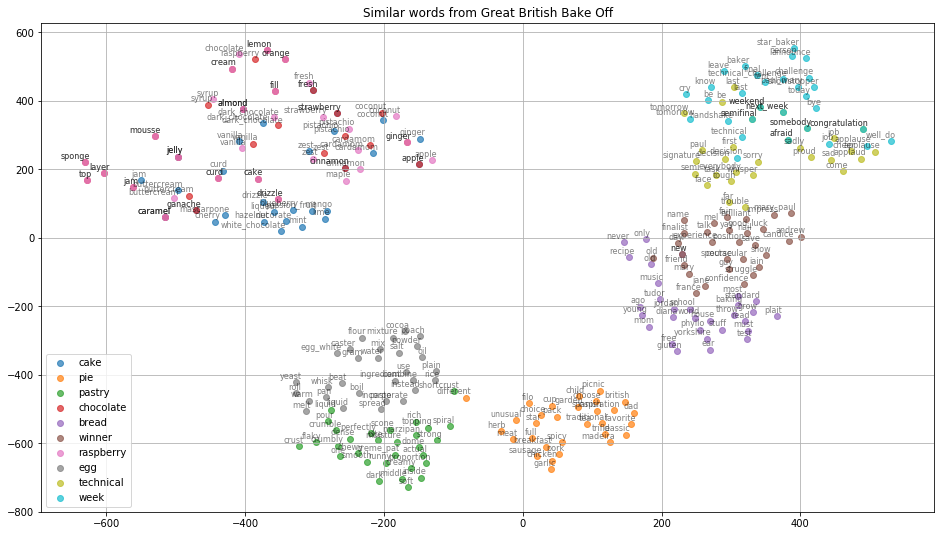

In [214]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

def tsne_plot_similar_words(title, keys, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.tab10(np.linspace(0, 1, len(keys)))
    for key, embeddings, words, color in zip(keys, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=key)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=0)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_similar_words('Similar words from Great British Bake Off', keys, embeddings_en_2d, word_clusters, 0.7,
                        'gbbo_similar_words.png')

## Vader Sentiment Analysis

Next, to gain further insights, I will do sentiment analysis for each row of dialogue. I will use this to perform sentiment analysis of each contestant over each of the seasons so that I can compare the sentiment of each contestant versus the ultimate winner of the season.

In [40]:
combo = []
pos = []
neu = []
neg = []

for i in df['dialogue']:
    combo.append(analyzer.polarity_scores(i)['compound'])
    pos.append(analyzer.polarity_scores(i)['pos'])
    neu.append(analyzer.polarity_scores(i)['neu'])
    neg.append(analyzer.polarity_scores(i)['neg'])

In [41]:
df['compound'] = combo
df['positive'] = pos
df['neutral'] = neu
df['negative'] = neg

In [42]:
conditions = [(df['compound']>0.05),
             ((df['compound'] > -0.05) & (df['compound'] < 0.05)),
             (df['compound'] < -0.05)]

choices = ['positive','neutral','negative']

df['sentiment'] = np.select(conditions,choices, default='neutral')

In [43]:
df.head()

,episode_num,season,episode,character,dialogue,role,gender,clean_text,compound,positive,neutral,negative,sentiment
0,101,1,1,mel,thousands of people applied it s been quite ...,host,female,thousand people apply be quite come today start,0.0000,0.000,1.000,0.000,neutral
1,101,1,1,mel,just have made it through and over the nex...,host,female,make over next week most excited tent walk sta...,0.4005,0.080,0.920,0.000,positive
2,101,1,1,mel,their baking will be scrutinized whatever th...,host,female,baking scrutinize experience,0.0000,0.000,1.000,0.000,neutral
3,101,1,1,woman,i ve been baking for years i suppose i m h...,contestant,female,be bake year suppose have chance last aren,0.2500,0.154,0.846,0.000,positive
4,101,1,1,man,the thing that worries me the most is probabl...,contestant,male,thing worry most probably open oven realize burn,-0.4215,0.000,0.851,0.149,negative


In [216]:
paul = df[df['character']=='paul']

In [217]:
paul[paul['sentiment']=='negative']

,episode_num,season,episode,character,dialogue,role,gender,clean_text,compound,positive,neutral,negative,sentiment
133,101,1,1,paul,in last place is this one couldn t find the ...,judge,male,last place couldn find cherry chop small evapo...,-0.1779,0.044,0.898,0.058,negative
140,101,1,1,paul,i can see a good handful of people doing real...,judge,male,good handful people really well nancy chetna m...,-0.1513,0.055,0.895,0.049,negative
210,101,1,1,paul,claire had some good ideas but unfortunately...,judge,male,claire good idea unfortunately mistake make kn...,-0.3818,0.148,0.654,0.198,negative
358,102,1,2,paul,did you make the fondant no i didn t,judge,male,do make fondant no didn,-0.2960,0.000,0.732,0.268,negative
393,103,1,3,paul,there is only one pumpernickel and that comes...,judge,male,only pumpernickel come germany well case poor ...,-0.2500,0.095,0.766,0.140,negative
477,103,1,3,paul,but we ve got a pita bread again,judge,male,get pita bread again,-0.6808,0.000,0.566,0.434,negative
523,103,1,3,paul,one of the issues is you get big gaps i m go...,judge,male,issue big gap go try roll fairly tightly try n...,-0.4019,0.049,0.840,0.111,negative
564,103,1,3,paul,there is no gap because inside is raw it s ...,judge,male,no gap inside raw raw,-0.2960,0.000,0.804,0.196,negative
884,105,1,5,paul,the pear s poached lovely pastry s got a bit...,judge,male,pear poach lovely pastry get bit crunch outsid...,-0.7371,0.036,0.850,0.114,negative
941,105,1,5,paul,her showstoppers today did look pretty bad at...,judge,male,showstopper today do pretty bad bottom top two...,-0.8036,0.094,0.734,0.173,negative


In [220]:
paul.iloc[1135,4]

' but the fruit tart  it was falling apart  and then scones  no flavor  then you have candice  who s this very creative baker  everything packed with flavor  now when you look at the actual quiche  she put loads and loads of salmon in there  but it did taste extremely good  her sausage rolls  i ve had many sausage rolls in my time    '

In [45]:
df['character'].unique()

array(['mel', 'woman', 'man', 'sue', 'mary', 'paul', 'diana', 'chetna',
       'claire', 'richard', 'jordan', 'enwezor', 'kate', 'martha', 'iain',
       'nancy', 'luis', 'both', 'norman', 'narrator', 'all', 'announcer',
       'peter', 'sarah', 'tim', 'girl', 'louise', 'glenn', 'ali', 'lucy',
       'howard', 'frances', 'mark', 'ruby', 'christine', 'robert', 'toby',
       'deborah', 'beca', 'kimberley', 'meg', 'rob', 'deirdre', 'kevin',
       'natalie', 'giuseppe', 'marie', 'nadiya', 'stu', 'ian', 'sandy',
       'ugne', 'dorret', 'flora', 'tamal', 'mat', 'alvin', 'jagger',
       'abdal', 'shoma', 'candice', 'andrew', 'val', 'benjamina',
       'michael', 'tom', 'rav', 'jane', 'selasi', 'judges', 'helen',
       'kay', 'nigel', 'amy', 'henry'], dtype=object)

In [46]:
generic = ['woman','man','both','narrator','announcer','girl','all','giuseppe','amy','henry','kay','judges',
          'abdal','shoma','helen','nigel']

for g in generic: 
    df.drop(df[df['character']==g].index, inplace=True)

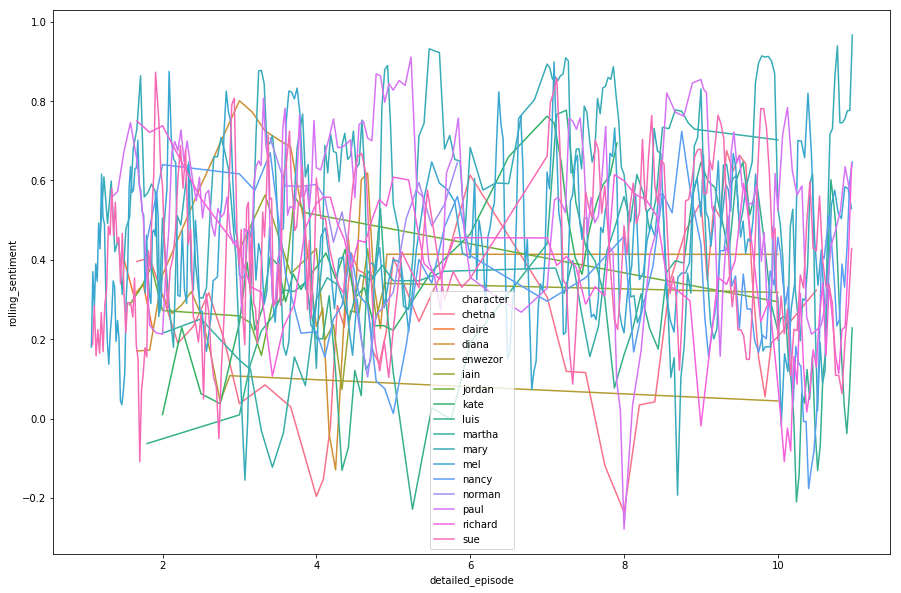

In [60]:
rolling_window = 5
list_of_mini_dfs = []
for character, mini_df in df.groupby(['character', 'season', 'episode']):
    mini_df['detailed_episode'] = mini_df['episode'] + np.linspace(0,1, mini_df.shape[0], endpoint=False)
    list_of_mini_dfs.append(mini_df)
    
foo = pd.concat(list_of_mini_dfs, axis=0)

list_of_foos = []
for character, mini_df in foo.groupby(['character', 'season']):
    if mini_df.shape[0] < rolling_window:
        continue
    mini_df['rolling_sentiment'] = mini_df['compound'].rolling(rolling_window).mean()
    mini_df = mini_df.dropna(subset=['rolling_sentiment'], axis=0)
    list_of_foos.append(mini_df)

food = pd.concat(list_of_foos, axis=0)

fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(x='detailed_episode', y='rolling_sentiment', hue='character', data=food[food.season==1], ax=ax)

In [59]:
food.head()

,episode_num,season,episode,character,dialogue,role,gender,clean_text,compound,positive,neutral,negative,sentiment,detailed_episode,rolling_sentiment
87,101,1,1,mary,it looks as classic as i can remember it has...,judge,female,look classic remember hasn be roll quite tight...,0.5666,0.090,0.857,0.053,positive,101.428571,0.45974
88,101,1,1,mary,you know where you went wrong yes yep your...,judge,female,know go wrong yes yep theory put cut way yeah ...,0.2023,0.201,0.650,0.150,positive,101.476190,0.46096
91,101,1,1,mary,it s pretty good isn t it i like that the c...,judge,female,pretty good isn like crunch nut outside coffee...,0.8268,0.330,0.601,0.069,positive,101.523810,0.48505
93,101,1,1,mary,it s just a bit bold and a bit fat and a bit ...,judge,female,bit bold bit fat bit big bold fat big norman m...,0.9403,0.266,0.734,0.000,positive,101.571429,0.55291
95,101,1,1,mary,you ve got a lovely spiral here that is f...,judge,female,get lovely spiral fantastic god sharpness come...,0.8591,0.333,0.667,0.000,positive,101.619048,0.54972


In [56]:
judges = df[df['role']=='judge']
judges.head()

,episode_num,season,episode,character,dialogue,role,gender,clean_text,compound,positive,neutral,negative,sentiment
18,101,1,1,mary,brand new year new bakers i can t wait to...,judge,female,brand new year new baker wait like be bake rea...,0.1901,0.042,0.958,0.000,positive
19,101,1,1,paul,swiss rolls are a great first signature chall...,judge,male,swiss roll great first signature challenge key...,0.8834,0.190,0.780,0.030,positive
41,101,1,1,paul,how big is this going to be i ve got to be c...,judge,male,big go get careful do past greedy yeah many ra...,0.3818,0.128,0.823,0.050,positive
43,101,1,1,mary,you ve got to get the spiral in the middle in...,judge,female,get spiral middle proportion sponge get middle...,0.5859,0.089,0.911,0.000,positive
58,101,1,1,mary,why have you done that because if you score ...,judge,female,do score prevent cracking roll want ok ready n...,0.2617,0.108,0.861,0.031,positive


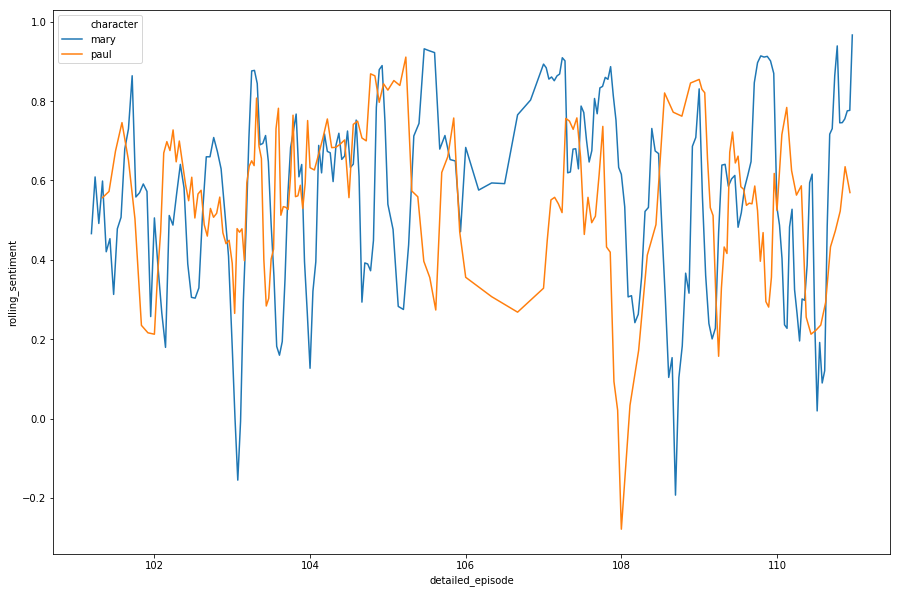

In [61]:
rolling_window = 5
list_of_mini_dfs = []
for character, mini_df in judges.groupby(['character', 'season', 'episode_num']):
    mini_df['detailed_episode'] = mini_df['episode_num'] + np.linspace(0,1, mini_df.shape[0], endpoint=False)
    list_of_mini_dfs.append(mini_df)
    
foo = pd.concat(list_of_mini_dfs, axis=0)

list_of_foos = []
for character, mini_df in foo.groupby(['character', 'season']):
    if mini_df.shape[0] < rolling_window:
        continue
    mini_df['rolling_sentiment'] = mini_df['compound'].rolling(rolling_window).mean()
    mini_df = mini_df.dropna(subset=['rolling_sentiment'], axis=0)
    list_of_foos.append(mini_df)

food = pd.concat(list_of_foos, axis=0)

fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(x='detailed_episode', y='rolling_sentiment', hue='character', data=food[food.season==1], ax=ax)

In [62]:
judges.to_csv('judges.csv',index=False)

In [67]:
contestants = df[df['role']=='contestant']
contestants.head()

,episode_num,season,episode,character,dialogue,role,gender,clean_text,compound,positive,neutral,negative,sentiment
22,101,1,1,diana,my daughters said keep calm mother so ...,contestant,female,daughter say keep calm mother treat school exa...,0.9322,0.180,0.820,0.0,positive
25,101,1,1,chetna,in india most sweets would have a touch of c...,contestant,female,india most sweet touch cardamom grow eat home ...,0.5413,0.137,0.863,0.0,positive
28,101,1,1,claire,me dad absolutely loves orange flavored choco...,contestant,female,dad absolutely love orange flavor chocolate fa...,0.9588,0.167,0.833,0.0,positive
30,101,1,1,richard,i ve just mixed up a pink mixture of my main ...,contestant,male,mix pink mixture main sponge lucky two daughte...,0.8094,0.229,0.771,0.0,positive
34,101,1,1,jordan,what i found out at home is that too much pin...,contestant,male,find out home pink take many many hour freeze ...,0.6486,0.116,0.884,0.0,positive


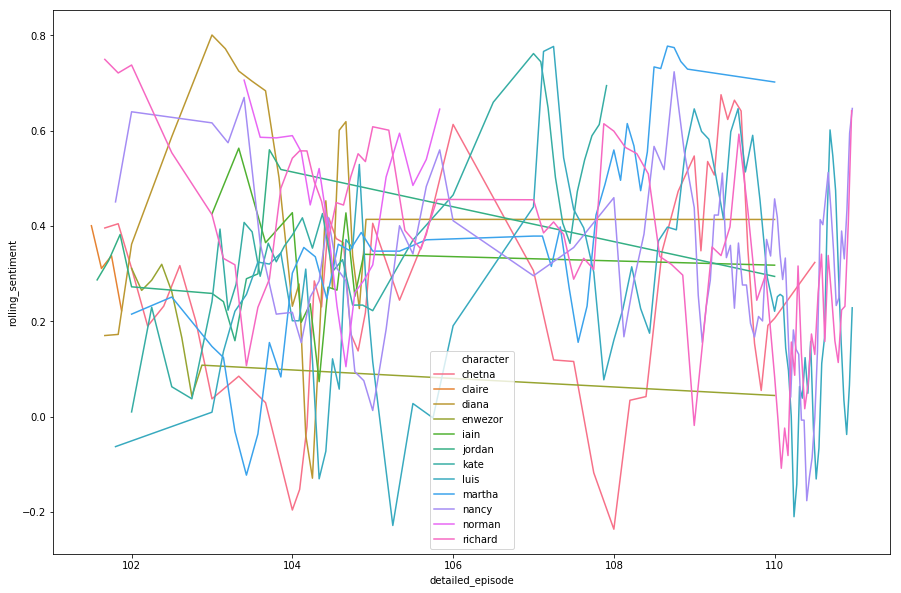

In [68]:
rolling_window = 5
list_of_mini_dfs = []
for character, mini_df in contestants.groupby(['character', 'season', 'episode_num']):
    mini_df['detailed_episode'] = mini_df['episode_num'] + np.linspace(0,1, mini_df.shape[0], endpoint=False)
    list_of_mini_dfs.append(mini_df)
    
foo = pd.concat(list_of_mini_dfs, axis=0)

list_of_foos = []
for character, mini_df in foo.groupby(['character', 'season']):
    if mini_df.shape[0] < rolling_window:
        continue
    mini_df['rolling_sentiment'] = mini_df['compound'].rolling(rolling_window).mean()
    mini_df = mini_df.dropna(subset=['rolling_sentiment'], axis=0)
    list_of_foos.append(mini_df)

food = pd.concat(list_of_foos, axis=0)

fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.lineplot(x='detailed_episode', y='rolling_sentiment', hue='character', data=food[food.season==1], ax=ax)

In [69]:
contestants.to_csv('contestants.csv', index=False)

## Find Positive and negatives from Word2Vec Findings

In [49]:
pairings = ['buttercream',
 'strawberry',
 'passion_fruit',
 'blueberry',
 'drizzle',
 'vanilla',
 'decorate',
 'curd',
 'pistachio', 
 'ganache']
cakes = []

for flavor in pairings:
    cake = df[df['dialogue'].str.contains(flavor)]
    cake['flavor'] = flavor
    cakes.append(cake)

/Users/amyksu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [50]:
cake_df = pd.concat(cakes)

In [51]:
cake_df.to_csv('cake2.csv', index=False)

In [101]:
pastry = ['thin','flaky','dense','evenly','inside','smooth','flake','soggy','crust','liquid']

pat = []
for p in pastry:
    print(p)
#     patisserie = df[df['dialogue'].str.contains(p)]
#     patisserie['flavor'] = p
#     pat.append(patisserie)

thin
flaky
dense
evenly
inside
smooth
flake
soggy
crust
liquid


In [99]:
pat_df = pd.concat(pat)

In [104]:
pat_df.to_csv('pastry.csv')

## Scattertext

In [52]:
import scattertext as st

In [79]:
corpus_g = st.CorpusFromPandas(contestants, 
                             category_col='gender', 
                             text_col='clean_text', 
                             nlp=st.whitespace_nlp_with_sentences).build()

In [81]:
html = st.produce_scattertext_explorer(
        corpus_g,
        category='female',
        category_name='Female',
        not_category_name='Male',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        metadata=contestants['character'],
        )

In [82]:
open('contestants.html', 'wb').write(html.encode('utf-8'));

## Percent of dialogue male vs female

In [90]:
total_dialogue = df.groupby(['episode_num','season','character', 'gender','role']).agg({'dialogue':'count'})
episode = df.groupby(['episode_num']).agg({'dialogue':'count'})
dialogue_by_character = total_dialogue.div(episode, level='episode_num') * 100
dialogue_by_character.to_csv('dialogue_perc.csv')